In [40]:
import os
import csv


def _extract_eval_eps(wdir):
    eval_dirs = []
    for dname in os.listdir(wdir):
        full_dname = os.path.join(wdir, dname)
        acts_fname = os.path.join(full_dname, 'ActionsPerEpisode.txt')
        if dname.startswith('evaluation_') and 'display' not in dname and \
                os.path.isdir(full_dname) and os.path.isfile(acts_fname):
            eval_dirs.append([acts_fname, int(dname.replace('evaluation_', ''))])
        
    eval_dirs = sorted(eval_dirs, key=lambda x:x[1])
    
    all_eps = {}
    for acts_fname, eval_idx in eval_dirs:
        eps = []
        with open(acts_fname) as f:
            for _, nr in csv.reader(f, delimiter='\t'):
                eps.append(int(float(nr)))
        all_eps[eval_idx] = eps
    
    keys = sorted(list(all_eps.keys()))
    cnt = set([len(all_eps[k]) for k in keys])
    assert len(cnt) <= 1, cnt
    if len(cnt) > 1:
        print('Different eval eps for {}: {}'.format(wdir, cnt))

    return all_eps, cnt

In [7]:

PATH_PREFIX = '../'
wdir = 'results/hpsearch-2021-09-06/best/1_run_168'

In [3]:
from neurosim.tools.eval_multimodel import _extract, _extract_params

wdirs, configs = _extract(wdir, PATH_PREFIX)
all_params, keys = _extract_params(wdirs, configs)

In [8]:
wdirs

['results/hpsearch-2021-09-01/run_106756',
 'results/hpsearch-2021-09-04/best/1_run_2703',
 'results/hpsearch-2021-09-06/best/1_run_168']

In [76]:

all_eval_eps = []
N_curr = None
for wdir in wdirs:
    eval_eps, N = _extract_eval_eps(os.path.join(PATH_PREFIX, wdir))
    if N:
        if N_curr:
            assert N_curr == N, 'curr:{}  this:{}'.format(N_curr, N)
        else:
            N_curr = N
            
    all_eval_eps.append(eval_eps)
    print(wdir, len(eval_eps))

results/hpsearch-2021-09-01/run_106756 2
results/hpsearch-2021-09-04/best/1_run_2703 2
results/hpsearch-2021-09-06/best/1_run_168 3


In [17]:

def _get_values(key):
    return [params[key] if key in params else None for params in all_params]
    

for key in keys:
    values = _get_values(key)
    if len(set(values)) > 1:
      print(key, values)

:STDP-RL:AMPA:RLantiwt [-0.02, -0.02, -0.03]
:STDP-RL:AMPA:RLhebbwt [0.02, 0.02, 0.03]
:STDP-RL:AMPA:RLlenanti [255, 204, 204]
:STDP-RL:AMPA:RLlenhebb [255, 204, 204]
:STDP-RL:AMPA:tauanti [50, 5, 5]
:STDP-RL:AMPA:tauhebb [50, 5, 5]
:critic:angv_bias [0.5, 1.0, 0.7]
:critic:clear_flips [None, True, False]
:critic:posRewardBias [1.5, 2.8, 2.8]
:critic:total_gain [3.0, 2.5, 2.5]
:net:popTargetFreq:EA [5.5, 5.5, 6.0]
:net:popTargetFreq:EM [6.0, 6.0, 7.1]
:sim:duration [500, 2000, 2000]
:sim:outdir ['results/hpsearch-2021-09-01/run_106756', 'results/hpsearch-2021-09-04/run_2703', 'results/hpsearch-2021-09-06/run_168']
:sim:recordWeightStepSize [1000, 10000, 5000]
:sim:resetEligTrace [None, 1, 1]
:sim:targetedNonEM [0, 1, 1]
:sim:targetedRLDscntFctr [0.5, 0.8, 0.5]
:sim:targetedRLMainFctr [None, None, 0.8]
:sim:targetedRLOppFctr [1.0, 0.8, 0.8]
:simtype:ResumeSim [0, 1, 1]
:simtype:ResumeSimFromFile ['results/20210714/synWeights_final.pkl', 'results/hpsearch-2021-09-01/run_106756/synWeights

In [61]:
current_steps = 0

# eps_meta = []
hprun_meta = {}
idx = 0
print('\t'.join(['idx', 'start', 'recSize', 'recs_cnt']))
for duration, recStepSize, tstepSize in zip(
        _get_values(':sim:duration'), _get_values(':sim:recordWeightStepSize'), _get_values(':sim:tstepPerAction')):
    total_steps = duration * 1000 / tstepSize
    total_recs = total_steps / recStepSize
    print('\t'.join([str(k) for k in [idx, current_steps, recStepSize, total_recs]]))
#     eps_meta.append([current_steps, recStepSize, total_recs])
    hprun_meta[idx] = dict([(k, int(current_steps + recStepSize * k)) for k in range(int(total_recs) + 1)])
    current_steps += total_steps
    idx += 1

idx	start	recSize	recs_cnt
0	0	1000	10.0
1	10000.0	10000	4.0
2	50000.0	5000	8.0


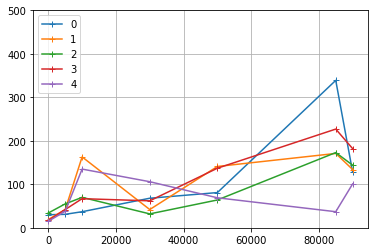

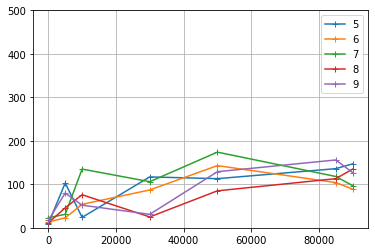

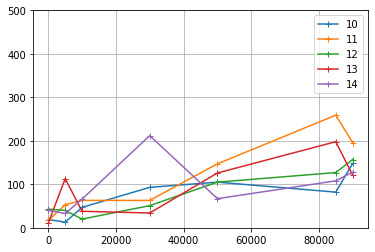

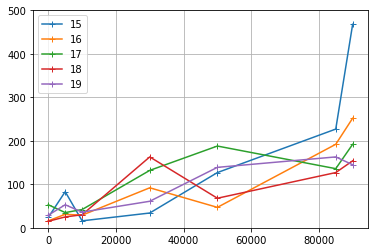

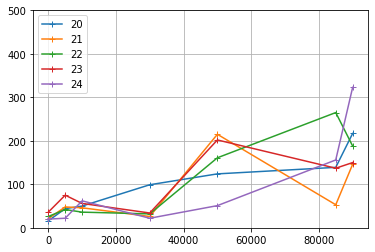

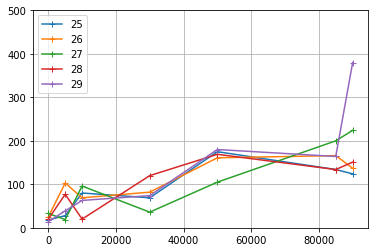

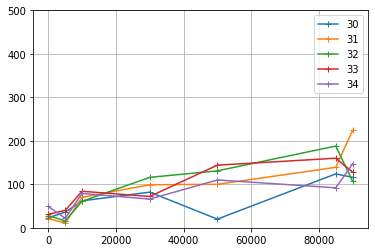

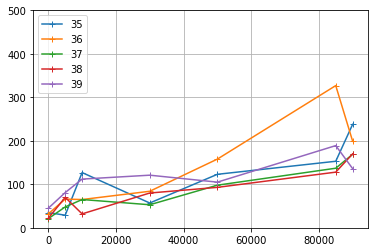

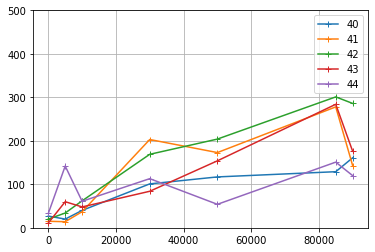

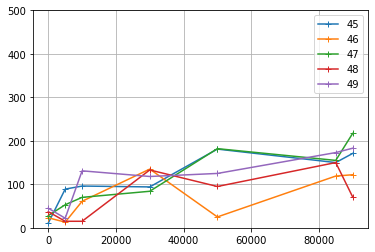

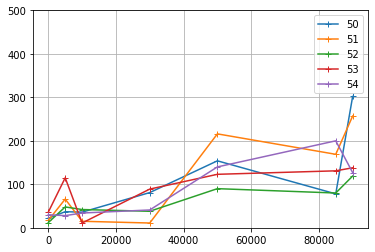

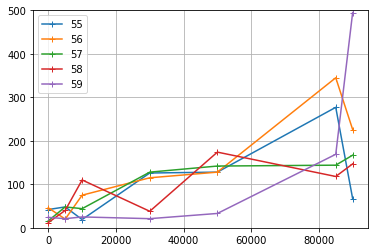

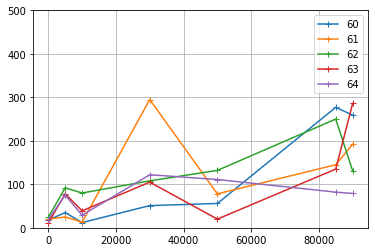

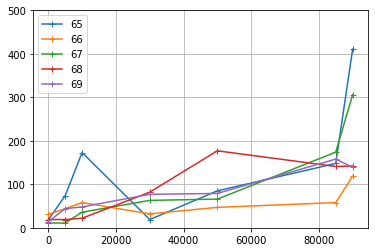

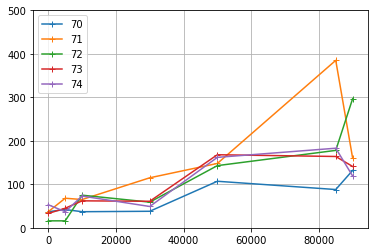

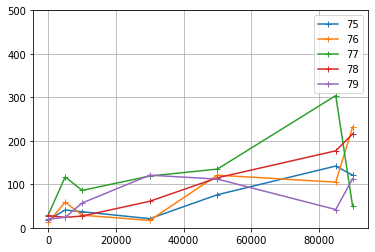

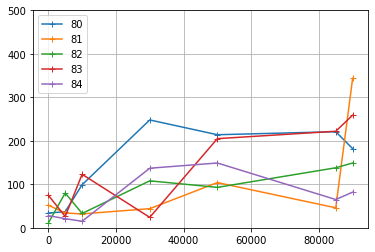

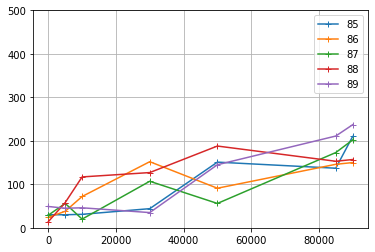

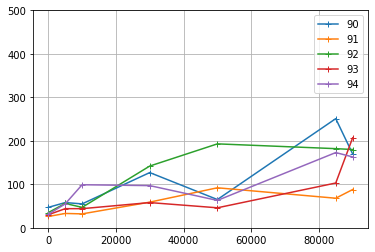

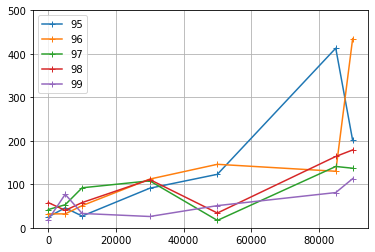

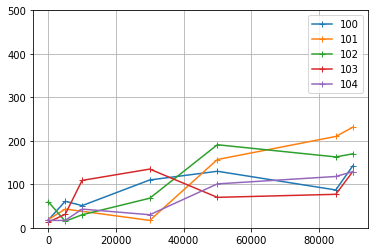

In [77]:
import matplotlib.pyplot as plt


keys = range(list(N_curr)[0])

start_idx = 0
EVERY=5
while True:
    for idx in range(start_idx, start_idx+EVERY):
    #     skeys = [k for k in keys if k % 5 == 0]
        x,y = [],[]
        for hprun_idx, hprun_eps in enumerate(all_eval_eps):
            for hprun_eidx, hprun_eval_vals in hprun_eps.items():
                x.append(hprun_meta[hprun_idx][hprun_eidx])
                y.append(hprun_eval_vals[idx])
#         skeys = keys
        plt.plot(x, y, '+-')
    
    plt.ylim(0, 500)
    plt.legend([start_idx + k for k in range(EVERY)])
    plt.grid()
    plt.show()
    start_idx += EVERY
    if start_idx> 100:
        break